## Phase 4: Council valuation dataset
### INPUTS
Council Ratings Valuation (RV) data:
-	xls file for 2011 RVs
-	xls file for 2014 RVs
-	xls file for 2017 RVs
-	xls file for 2021 RVs [to be received later in the year]

### OUTPUTS
Four csv files (one for 2011, 2014, 2017 and 2021) with the following data fields added:
-	The same data fields listed through points 1-9 above under Phase 0 are to be added to each ratings valuation after each RV is matched to a parcel.
o	Naming convention: Use the same labels as given under Phase 1 (in red).


In [1]:
#pragma nodebook off
#Use nodebook for better reproducibility https://github.com/uoa-eResearch/nodebook
%reload_ext nodebook.ipython
%nodebook disk phase4

<IPython.core.display.Javascript object>

In [2]:
# load libraries
import geopandas as gpd # vector data
import pandas as pd # tabular data, loading CSVs
import numpy as np # numeric data
from util import *
import matplotlib # plotting
import contextily as ctx # Used for contextual basemaps
from matplotlib_scalebar.scalebar import ScaleBar # scalebar for plot
import matplotlib.pyplot as plt # plotting
from tqdm.auto import tqdm # progress bars
tqdm.pandas()
import json
from scipy.spatial import cKDTree
from shapely.geometry import Point, shape, LineString, MultiLineString, GeometryCollection, MultiPoint, Polygon  # creating points
import requests
import requests_cache
requests_cache.install_cache('requests_cache')
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
plt.rcParams['figure.figsize'] = (20, 20)
pd.set_option('max_columns', None)

In [6]:
%%time
rvs = {}
for year in tqdm([2011, 2014, 2017]):
    rvs[year] = pd.read_excel(f"restricted/REVAL{year} Property Data Supply.xlsx")

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 19min 50s, sys: 5.57 s, total: 19min 56s
Wall time: 19min 55s


10.	Because titles can be cumbersome to work with, please add a unique numeric identifier for each RV in the dataset based on its certificate of title. Call it ‘FID_certificate_of_title’. 

In [7]:
rvs[2017]

,Valuation_Number_Roll,Valuation_Number_Assessment,Valuation_Number_Suffix,District_Code,Situation_Number,Additional_Situation_Number,Situation_Name,Legal_Description,Land_Area,Property_Category,Ownership_Code,Current_Effective_Valuation_Date,Capital_Value,Improvements_Value,Land_Value,Trees,REVISED_CAPITAL_VALUE,REVISED_IMPROVEMENTS_VALUE,REVISED_LAND_VALUE,REVISED_TREES,Improvements_Description,Certificate_of_Title,Additional_Certificate_of_Title,Zoning,Actual_Property_Use,Units_of_Use,Off_street_Parking,Building_Age_Indicator,Building_Condition_Indicator,Building_Construction_Indicator,Building_Site_Coverage,Building_Total_Floor_Area,Mass_Contour,Mass_View,Mass_Scope_of_View,Mass_Total_Living_Area,Mass_Deck,Mass_Workshop_Laundry,Mass_Other_Improvements,Mass_Garage_Freestanding,Mass_Garage_Under_Main_Roof,Sales_Group
0,38703,44617,NaN,14,84.0,NaN,REYNOLDS RD,LOT 17 DP344916,0.0836,RD201B,1.0,2014-07-01,860000,450000,410000,NaN,0,0,0,0,DWG GGE OI,184249,N,9B,91,1.0,3.0,201,GG,BT,229.0,229.0,ER,O,S,173.0,N,N,N,NaN,3.0,1002
1,38703,44618,NaN,14,82.0,NaN,REYNOLDS RD,LOT 18 DP344916,0.0829,RD200B,1.0,2014-07-01,820000,410000,410000,NaN,0,0,0,0,DWG OI,184250,N,9B,91,1.0,NaN,200,GG,BT,222.0,222.0,ER,O,M,184.0,N,N,N,NaN,2.0,1002
2,38703,44619,NaN,14,80.0,NaN,REYNOLDS RD,LOT 19 DP344916,0.0839,RD200B,1.0,2014-07-01,820000,410000,410000,NaN,0,0,0,0,DWG OI,184251,N,9B,91,1.0,NaN,200,GG,BT,212.0,212.0,ER,O,S,172.0,N,N,N,NaN,2.0,1002
3,38703,44621,NaN,14,22.0,NaN,REYNOLDS RD,LOT 21 DP344916,5.5664,OS,4.0,2014-07-01,1080000,5000,1075000,NaN,0,0,0,0,OB,184253,N,5A,55,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002
4,38703,44622,NaN,14,NaN,NaN,REYNOLDS RD,LOT 22 DP344916,1.7965,OP,4.0,2014-07-01,500000,0,500000,NaN,0,0,0,0,NaN,184254,N,5B,55,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549931,2390,50700,B,14,33.0,A,Ellerton Road,"Flat 2 DP 114220, Lot 1 DP 111459 938m2",0.0000,RD198B,1.0,2014-07-01,1475000,275000,1200000,0.0,1475000,275000,1200000,0,HOUSE,65A/204,N,9B,91,1.0,1.0,198,GG,BT,110.0,172.0,LV,N,N,120.0,Y,N,N,0.0,1.0,730
549932,2400,33400,NaN,14,84.0,NaN,Peary Road,Lot 54 DP 20380 518m2,0.0518,RD192B,1.0,2014-07-01,1360000,140000,1220000,0.0,1360000,140000,1220000,0,HOUSE,454/190,N,9A,91,1.0,0.0,192,FF,WI,120.0,119.0,LV,N,N,119.0,N,N,N,0.0,0.0,730
549933,2400,34500,NaN,14,106.0,NaN,Peary Road,Lot 43 DP 17805 822m2,0.0822,RD191B,1.0,2014-07-01,2000000,550000,1450000,0.0,2000000,550000,1450000,0,HOUSE & GARAGE,82C/174,N,9A,91,1.0,1.0,191,AA,WI,190.0,260.0,LV,N,N,260.0,Y,N,N,1.0,0.0,730
549934,2400,34900,NaN,14,114.0,NaN,Peary Road,Lot 39 DP 17805 541m2,0.0541,RD192A,1.0,2014-07-01,1650000,410000,1240000,0.0,1650000,410000,1240000,0,HOUSE & GARAGE,413/13,N,9A,91,1.0,2.0,192,AA,WI,140.0,145.0,LV,N,N,145.0,N,N,N,2.0,0.0,730


In [8]:
for rv in rvs.values():
    rv.Certificate_of_Title = rv.Certificate_of_Title.astype(str)

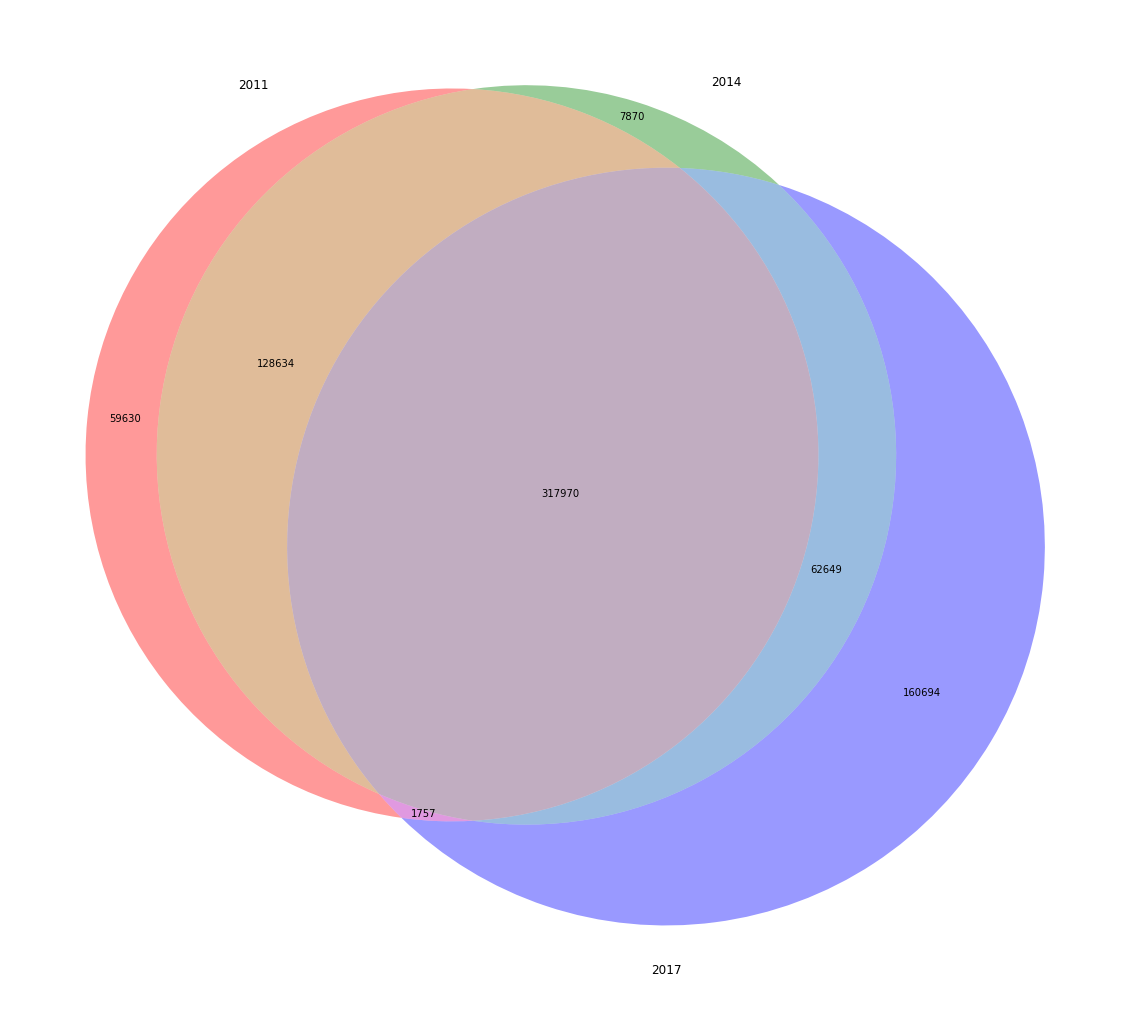

In [9]:
venn3([set(rv.Certificate_of_Title.str.replace("NA", "")) for rv in rvs.values()], set_labels = rvs.keys())

In [10]:
# The for loop above would set rv to the last element, so RV for 2017
len(rv.Certificate_of_Title), len(rv.Certificate_of_Title.unique())

(549936, 543313)

In [11]:
all_cots = pd.concat(rv.Certificate_of_Title for rv in rvs.values()).unique()
all_cots.sort()
print(len(all_cots))
all_cots = {cot: i for i, cot in enumerate(all_cots)}

740915


In [12]:
%%time
for rv in rvs.values():
    rv["FID_certificate_of_title"] = rv.Certificate_of_Title.progress_apply(lambda cot: all_cots[cot])

  0%|          | 0/516469 [00:00<?, ?it/s]

  0%|          | 0/529046 [00:00<?, ?it/s]

  0%|          | 0/549936 [00:00<?, ?it/s]

CPU times: user 4.77 s, sys: 64.2 ms, total: 4.84 s
Wall time: 4.8 s


PROCEDURE FOR MATCHING RVs TO LINZ DATABASE  
Use certificate of title to match each valuation to a LINZ parcel(s). 

11.	Indicator for one-to-many matched LINZ parcels: ‘One_to_many_matched_parcels’  
a.	Equal to one or zero
12.	Indicator for many-to-one matched LINZ parcel: ‘Many_to_one_matched_parcels’  
a.	Equal to one or zero  

In [13]:
%%time
parcels = gpd.read_file('input/lds-nz-primary-parcels-FGDB.zip!nz-primary-parcels.gdb').to_crs(2193).set_index("id")
addresses = gpd.read_file('input/lds-nz-addresses-pilot-FGDB.zip!nz-addresses-pilot.gdb').to_crs(2193)
def number_name_addresses(x):
    return ' '.join(x.split(' ')[:2]).lower()
addresses['address_number_name'] = addresses.full_address_ascii.apply(number_name_addresses)
parcels_addressed = gpd.sjoin(parcels, addresses)
parcels["addresses"] = parcels_addressed.groupby('id')['address_number_name'].apply(list)
parcels["full_addresses"] = parcels_addressed.groupby('id')["full_address"].apply(list)
parcels[["addresses", "full_addresses"]]

CPU times: user 4min 8s, sys: 19.5 s, total: 4min 28s
Wall time: 4min 28s


,addresses,full_addresses
id,,
4918991,"[3/12 college, 1/12 college, 2/12 college, 12 ...","[3/12 College Road, Saint Johns, Auckland, 1/1..."
4919914,[15 abraham],"[15 Abraham Place, Saint Johns, Auckland]"
4926734,"[3/20 simkin, 1/20 simkin, 2/20 simkin, 20 sim...","[3/20 Simkin Avenue, Saint Johns, Auckland, 1/..."
4926945,"[3 abraham, 4/3 abraham, 3/3 abraham, 2/3 abra...","[3 Abraham Place, Saint Johns, Auckland, 4/3 A..."
4929034,[49 caulton],"[49 Caulton Street, Saint Johns, Auckland]"
...,...,...
5227472,[112z bairds],"[112Z Bairds Road, Ōtara, Auckland]"
5242816,NaN,NaN
7520053,[9 lovegrove],"[9 Lovegrove Crescent, Ōtara, Auckland]"


In [14]:
for year, rv in rvs.items():
    RV_NAs = sum(rv.Certificate_of_Title.str.contains('NA'))
    print(f"{RV_NAs} RV titles from {year} start with NA / {len(rv)} ({round(RV_NAs/len(rv)*100, 2)}%)")
parcels_NAs = sum(parcels.titles.str.contains('NA', na=False))
print(f"{parcels_NAs} parcel titles start with NA / {len(parcels)} ({round(parcels_NAs/len(parcels)*100, 2)}%)")

284487 RV titles from 2011 start with NA / 516469 (55.08%)
321794 RV titles from 2014 start with NA / 529046 (60.83%)
322573 RV titles from 2017 start with NA / 549936 (58.66%)
345003 parcel titles start with NA / 547903 (62.97%)


In [15]:
rv.Certificate_of_Title = rv.Certificate_of_Title.str.replace("NA", "")
parcels.titles = parcels.titles.str.replace("NA","")

In [16]:
split_titles = parcels.titles.str.split(", ").explode().dropna().str.upper()
split_titles

id
4918991      8C/911
4919914      474924
4919914      8C/768
4926734      386353
4926734      386354
             ...   
5093286    111B/230
5184362     56B/639
7520053      621250
7520049      619244
4733845     86D/103
Name: titles, Length: 723468, dtype: object

In [17]:
print(sum(rv.Certificate_of_Title.isin(parcels.titles)))
print(sum(rv.Certificate_of_Title.str.upper().isin(parcels.titles.str.upper())))
print(sum(rv.Certificate_of_Title.str.upper().isin(split_titles)))

351924
352018
528203


In [18]:
title_lookup = {}
for parcel_id, title in split_titles.iteritems():
    if title not in title_lookup:
        title_lookup[title] = []
    title_lookup[title].append(parcel_id)

In [19]:
%%time
for year, rv in tqdm(rvs.items()):
    rv["matched_parcels"] = rv.Certificate_of_Title.str.replace("NA", "").str.upper().progress_apply(
        lambda t: title_lookup.get(t, [])
    )
    rv["number_of_matched_parcels"] = rv.matched_parcels.str.len()
    rv["One_to_many_matched_parcels"] = (rv.number_of_matched_parcels > 1).astype(int)
    rv["LINZ_parcel_ID"] = rv.matched_parcels.str[0]
    rv["Many_to_one_matched_parcels"] = (~pd.isna(rv.LINZ_parcel_ID) & rv.LINZ_parcel_ID.duplicated(keep=False)).astype(int)
    rvs[year] = rv

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/516469 [00:00<?, ?it/s]

  0%|          | 0/529046 [00:00<?, ?it/s]

  0%|          | 0/549936 [00:00<?, ?it/s]

CPU times: user 10.6 s, sys: 40.4 ms, total: 10.6 s
Wall time: 10.6 s


In [20]:
%%time
for year, rv in tqdm(rvs.items()):
    n_matched = sum(rv.number_of_matched_parcels > 0)
    print(f"{year}: {n_matched} parcels matched out of {len(rv)} ({round(n_matched/len(rv)*100,2)}%)")

  0%|          | 0/3 [00:00<?, ?it/s]

2011: 313530 parcels matched out of 516469 (60.71%)
2014: 372162 parcels matched out of 529046 (70.35%)
2017: 528203 parcels matched out of 549936 (96.05%)
CPU times: user 178 ms, sys: 7.97 ms, total: 186 ms
Wall time: 182 ms


In [21]:
rv.number_of_matched_parcels.value_counts()

1      468748
2       47589
0       21733
3        7158
4        2001
5        1229
10        537
6         364
8         200
7         137
13         69
9          46
27         46
12         36
11         10
14          6
15          3
18          3
19          3
41          3
23          2
57          2
20          1
16          1
29          1
91          1
21          1
30          1
32          1
22          1
189         1
37          1
17          1
Name: number_of_matched_parcels, dtype: int64

In [22]:
rv.One_to_many_matched_parcels.value_counts()

0    490481
1     59455
Name: One_to_many_matched_parcels, dtype: int64

In [23]:
rv["Many_to_one_matched_parcels"].value_counts()

0    361682
1    188254
Name: Many_to_one_matched_parcels, dtype: int64

#### Geocode the RV addresses and then follow the matching process detailed in Phase 1 for those that failed to match on title alone. Set LINZ_MATCH_CODE=0 for those that did.

In [24]:
for year, rv in tqdm(rvs.items()):
    rv.loc[rv.number_of_matched_parcels > 0, "LINZ_MATCH_CODE"] = 0

  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
rv[["Situation_Number", "Additional_Situation_Number", "Situation_Name"]].sample(20)

,Situation_Number,Additional_Situation_Number,Situation_Name
55044,321.0,NaN,Titirangi Rd
114265,3.0,NaN,Gloucester Park Road
480470,221.0,NaN,Abbotts WY
237,27.0,NaN,JAMES EVANS DR
468689,134.0,A-2,KOLMAR RD
506317,14.0,1,Cormack ST
58329,15.0,NaN,WAYLEN PL
503443,20.0,NaN,Burnside Avenue
139281,3.0,B,TRISTRAM AVE
172253,5.0,NaN,SAN ANGELO CT


In [26]:
for year, rv in tqdm(rvs.items()):
    rvs_with_addresses = rv[(rv.Situation_Number > 0) & ~pd.isna(rv.Situation_Name)].copy()
    rvs_with_addresses.Situation_Number = rvs_with_addresses.Situation_Number.astype("Int64").astype(str)
    rvs_with_addresses.Additional_Situation_Number = rvs_with_addresses.Additional_Situation_Number.replace(np.nan, "").astype(str)
    rv["full_address"] = rvs_with_addresses.Situation_Number.str.cat(
        rvs_with_addresses.Additional_Situation_Number
    ).str.cat(
        rvs_with_addresses.Situation_Name,
        sep=" "
    )
    rv["number_name"] = rv.full_address[~pd.isna(rv.full_address)].apply(lambda a: " ".join(a.lower().split()[:2]))

  0%|          | 0/3 [00:00<?, ?it/s]

In [27]:
for year, rv in tqdm(rvs.items()):
    print(year, any(rv.full_address.str.contains("[āēīōū]", na=False)))

  0%|          | 0/3 [00:00<?, ?it/s]

2011 False
2014 False
2017 False


In [28]:
rv.LINZ_MATCH_CODE.value_counts(dropna=False)

0.0    528203
NaN     21733
Name: LINZ_MATCH_CODE, dtype: int64

In [29]:
print(sum(rv.number_name.isin(addresses.address_number_name)))
print(sum(pd.isna(rv.LINZ_MATCH_CODE) & ~pd.isna(rv.full_address)))
print(sum(rv.number_name[pd.isna(rv.LINZ_MATCH_CODE)].isin(addresses.address_number_name)))

477736
19730
15847


In [31]:
session = requests_cache.CachedSession('requests_cache')
def geocode(address):
    url = f"https://api-proxy.auckland-cer.cloud.edu.au/nominatim/search.php"
    result = session.get(url, params={
        "q": address + ", Auckland"
    }).json()
    if result:
        return pd.Series(result[0])
    else:
        return pd.Series()
geocoding_results = {}
for year, rv in tqdm(rvs.items()):
    df = rv.full_address[pd.isna(rv.LINZ_MATCH_CODE) & ~pd.isna(rv.full_address)].progress_apply(geocode).dropna()
    df["number_name"] = rv.number_name[df.index]
    df["full_address"] = rv.full_address[df.index]
    geocoding_results[year] = df

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/199809 [00:00<?, ?it/s]

/tmp/ipykernel_837899/4130629444.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series()


  0%|          | 0/153931 [00:00<?, ?it/s]

  0%|          | 0/19730 [00:00<?, ?it/s]

In [32]:
df[["number_name", "full_address", "display_name"]][~df.display_name.str.contains("Auckland")]

,number_name,full_address,display_name
113557,233 pukekohe,233 PUKEKOHE EAST RD,"233, Pukekohe East Road, Pukekohe East, Frankl..."
113592,629 paparimu,629 Paparimu RD,"629, Paparimu Road, Franklin, Waikato District..."
113594,2213 east,2213 EAST COAST RD,"2213, East Coast Road, Franklin, Hauraki Distr..."
140090,309a upper,309A UPPER QUEEN ST,"309A, Upper Queen Street, Pukekohe, Franklin, ..."
168014,19 attewell,19 ATTEWELL RD,"19, Attewell Road, Pukekohe, Franklin, Waikato..."
168023,97 attewell,97 ATTEWELL RD,"97, Attewell Road, Pukekohe, Franklin, Waikato..."
168029,112 attewell,112 ATTEWELL RD,"112, Attewell Road, Pukekohe, Franklin, Waikat..."
226139,139c mill,139C MILL RD,"139C, Mill Road, Pukekohe East, Franklin, Waik..."
257818,93 logan,93 Logan RD,"93, Logan Road, Buckland, Franklin, Waikato Di..."
257850,52 golding,52 GOLDING RD,"52, Golding Road, Pukekohe, Franklin, Waikato ..."


In [33]:
for year, df in tqdm(geocoding_results.items()):
    df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs=4326).to_crs(2193)
    df = gpd.sjoin(df, parcels[["addresses","geometry"]], how="left")
    df = df.rename(columns={"index_right": "LINZ_parcel_ID"})
    df.LINZ_parcel_ID = df.LINZ_parcel_ID.astype("Int64")
    geocoding_results[year] = df

  0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
%%time
def check_match(row):
    if row.number_name in row.addresses:
        return 1
for year, df in tqdm(geocoding_results.items()):
    df["LINZ_MATCH_CODE"] = df[~pd.isna(df.addresses)].apply(check_match, axis=1).dropna()
    print(f"{year}: {sum(df.LINZ_MATCH_CODE == 1)}")

  0%|          | 0/3 [00:00<?, ?it/s]

2011: 27453
2014: 21788
2017: 13349
CPU times: user 7.96 s, sys: 11.1 ms, total: 7.97 s
Wall time: 7.97 s


In [35]:
parcel_tree = cKDTree(list(parcels.centroid.apply(lambda x: (x.x, x.y))))
parcel_tree

In [36]:
def find_match_in_range(row):
    indices_in_range = parcel_tree.query_ball_point([row.geometry.x, row.geometry.y], 1250)
    potential_matches = parcels.iloc[indices_in_range]
    match = potential_matches[potential_matches.addresses.str.contains(row.number_name, na=False, regex=False)]
    if len(match):
        row.LINZ_parcel_ID = match.index[0]
        row.addresses = match.addresses.iloc[0]
        row.full_addresses = match.full_addresses.iloc[0]
        row.LINZ_MATCH_CODE = 2
    return row
for year, df in tqdm(geocoding_results.items()):
    matches = df[
        ~pd.isna(df.number_name) &
        pd.isna(df["LINZ_MATCH_CODE"]) &
        df.number_name.isin(addresses.address_number_name)].progress_apply(find_match_in_range, axis=1)
    df.update(matches)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12405 [00:00<?, ?it/s]

  0%|          | 0/9894 [00:00<?, ?it/s]

  0%|          | 0/2239 [00:00<?, ?it/s]

In [37]:
for year, df in tqdm(geocoding_results.items()):
    print(year)
    display(df.LINZ_MATCH_CODE.value_counts(dropna=False))

  0%|          | 0/3 [00:00<?, ?it/s]

2011


NaN    154088
1.0     27453
2.0      2171
Name: LINZ_MATCH_CODE, dtype: int64

2014


NaN    103986
1.0     21788
2.0      1869
Name: LINZ_MATCH_CODE, dtype: int64

2017


1.0    13349
NaN     4242
2.0     1545
Name: LINZ_MATCH_CODE, dtype: int64

In [38]:
%%time
number_name_lookup = {}
for parcel_id, addresses in parcels.addresses[~pd.isna(parcels.addresses)].iteritems():
    for address in addresses:
        if address not in number_name_lookup:
            number_name_lookup[address] = []
        number_name_lookup[address].append(parcel_id)

CPU times: user 5.1 s, sys: 7.29 ms, total: 5.11 s
Wall time: 5.08 s


In [39]:
number_name_lookup["3/12 college"]

[4918991]

In [40]:
%%time
def find_text_match(row):
    matching_ids = number_name_lookup.get(row.number_name)
    if len(matching_ids):
        match = parcels.loc[matching_ids]
        closest_parcel_id = match.distance(row.geometry).idxmin()
        row.LINZ_parcel_ID = closest_parcel_id
        row.addresses = match.addresses[closest_parcel_id]
        row.full_addresses = match.full_addresses[closest_parcel_id]
        row.LINZ_MATCH_CODE = 3
    return row
for year, df in tqdm(geocoding_results.items()):
    matches = df[pd.isna(df["LINZ_MATCH_CODE"]) & df.number_name.isin(number_name_lookup.keys())].progress_apply(find_text_match, axis=1)
    df.update(matches)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10234 [00:00<?, ?it/s]

  0%|          | 0/8025 [00:00<?, ?it/s]

  0%|          | 0/694 [00:00<?, ?it/s]

CPU times: user 1min 17s, sys: 1 s, total: 1min 18s
Wall time: 1min 18s


In [41]:
for year, df in tqdm(geocoding_results.items()):
    df["Ranged_Address_indicator"] = df.full_address.str.contains('\d\w?\s?-', regex=True, na=False)
    df[df.Ranged_Address_indicator]
    print(f"{year}: {sum(df.Ranged_Address_indicator)} ranged addresses")

  0%|          | 0/3 [00:00<?, ?it/s]

2011: 407 ranged addresses
2014: 330 ranged addresses
2017: 242 ranged addresses


In [42]:
for year, df in tqdm(geocoding_results.items()):
    maybe_subdivision = df[df.number_name.str.contains("/") & pd.isna(df.LINZ_MATCH_CODE)].copy()
    if len(maybe_subdivision):
        maybe_subdivision.number_name = maybe_subdivision.number_name.str.split("/").str[-1]
        # step 1
        match = maybe_subdivision[~pd.isna(maybe_subdivision.addresses)].apply(check_match, axis=1)
        if len(match):
            maybe_subdivision["LINZ_MATCH_CODE"] = match
        else:
            maybe_subdivision["LINZ_MATCH_CODE"] = np.nan
        # step 2
        matches = maybe_subdivision[
            pd.isna(match) &
            maybe_subdivision.number_name.isin(number_name_lookup.keys())
        ].apply(find_match_in_range, axis=1)
        maybe_subdivision.update(matches)
        # step 3
        matches = maybe_subdivision[
            pd.isna(maybe_subdivision["LINZ_MATCH_CODE"]) & maybe_subdivision.number_name.isin(number_name_lookup.keys())
        ].apply(find_text_match, axis=1)
        maybe_subdivision.update(matches)
        maybe_subdivision.LINZ_MATCH_CODE = maybe_subdivision.LINZ_MATCH_CODE.replace({1: 4, 2: 5, 3: 6})
        df.update(maybe_subdivision)

    def strip_char(s):
        number, name = s.split()
        number = "".join([c for c in number if c.isnumeric()])
        return number + " " + name
    maybe_subdivision = df[
        df.number_name.str.contains("[0-9][a-zA-Z] ") &
        pd.isna(df.LINZ_MATCH_CODE)
    ].copy()
    if len(maybe_subdivision):
        maybe_subdivision.number_name = maybe_subdivision.number_name.apply(strip_char)
        # step 1
        match = maybe_subdivision[~pd.isna(maybe_subdivision.addresses)].apply(check_match, axis=1)
        if len(match):
            maybe_subdivision["LINZ_MATCH_CODE"] = match
        else:
            maybe_subdivision["LINZ_MATCH_CODE"] = np.nan
        # step 2
        matches = maybe_subdivision[
            pd.isna(match) &
            maybe_subdivision.number_name.isin(number_name_lookup.keys())
        ].apply(find_match_in_range, axis=1)
        maybe_subdivision.update(matches)
        # step 3
        matches = maybe_subdivision[
            pd.isna(maybe_subdivision["LINZ_MATCH_CODE"]) & maybe_subdivision.number_name.isin(number_name_lookup.keys())
        ].apply(find_text_match, axis=1)
        maybe_subdivision.update(matches)
        maybe_subdivision.LINZ_MATCH_CODE = maybe_subdivision.LINZ_MATCH_CODE.replace({1: 4, 2: 5, 3: 6})
        df.update(maybe_subdivision)

  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
def check_street_match(row):
    if row.number_name and len(row.number_name)>1:
        street = row.number_name.split()[-1]
        if street in str(row.addresses):
            return 7
    return np.nan
for year, df in tqdm(geocoding_results.items()):
    street_matches = df[pd.isna(df.LINZ_MATCH_CODE)].progress_apply(check_street_match, axis=1)
    df.LINZ_MATCH_CODE.update(street_matches)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/143116 [00:00<?, ?it/s]

  0%|          | 0/95283 [00:00<?, ?it/s]

  0%|          | 0/3056 [00:00<?, ?it/s]

In [44]:
for year, df in tqdm(geocoding_results.items()):
    df.LINZ_MATCH_CODE[~pd.isna(df.LINZ_parcel_ID) & pd.isna(df.LINZ_MATCH_CODE)] = 8
    df.LINZ_MATCH_CODE.fillna(9, inplace=True)
    geocoding_results[year] = df

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_837899/3355960595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.LINZ_MATCH_CODE[~pd.isna(df.LINZ_parcel_ID) & pd.isna(df.LINZ_MATCH_CODE)] = 8


In [45]:
for year, df in tqdm(geocoding_results.items()):
    print(year)
    display(df.LINZ_MATCH_CODE.value_counts(dropna=False))

  0%|          | 0/3 [00:00<?, ?it/s]

2011


8.0    140704
1.0     27453
3.0     10234
7.0      2412
2.0      2171
6.0       705
5.0        32
4.0         1
Name: LINZ_MATCH_CODE, dtype: int64

2014


8.0    93417
1.0    21788
3.0     8025
2.0     1869
7.0     1866
6.0      644
5.0       32
4.0        2
Name: LINZ_MATCH_CODE, dtype: int64

2017


1.0    13349
8.0     2623
2.0     1545
3.0      694
6.0      464
7.0      433
5.0       25
4.0        3
Name: LINZ_MATCH_CODE, dtype: int64

In [46]:
for year, df in tqdm(geocoding_results.items()):
    print(year)
    display(df.LINZ_MATCH_CODE[df.Ranged_Address_indicator].value_counts(dropna=False))

  0%|          | 0/3 [00:00<?, ?it/s]

2011


8.0    306
7.0     51
1.0     49
3.0      1
Name: LINZ_MATCH_CODE, dtype: int64

2014


8.0    243
7.0     45
1.0     41
3.0      1
Name: LINZ_MATCH_CODE, dtype: int64

2017


8.0    187
7.0     36
1.0     19
Name: LINZ_MATCH_CODE, dtype: int64

In [47]:
for year, df in tqdm(geocoding_results.items()):
    rvs[year].update(df)
    rvs[year]["geocoded_lat"] = df.lat
    rvs[year]["geocoded_lon"] = df.lon
    rvs[year]["geocoded_address"] = df.display_name
    distances = df[~pd.isna(df.LINZ_parcel_ID)].distance(parcels.loc[df.LINZ_parcel_ID[~pd.isna(df.LINZ_parcel_ID)]], align=False)
    rvs[year]["distance_to_parcel"] = distances
    rvs[year]["distance_to_parcel"] = rvs[year]["distance_to_parcel"].fillna(0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [48]:
for year, rv in tqdm(rvs.items()):
    rvs[year]["LINZ_MATCH_CODE"].fillna(9, inplace=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
# Things which can't be geocoded
for addr in rv.full_address[(rv.LINZ_MATCH_CODE == 9) & ~pd.isna(rv.full_address)]:
    print(addr)

8Z BIRMINGHAM RD
259R BAIRDS RD
12W BANBURY PL
19 NOR EAST DR
37 NOR EAST DR
39 NOR EAST DR
41 NOR EAST DR
43 NOR EAST DR
45 NOR EAST DR
47 NOR EAST DR
49 NOR EAST DR
16 NOR EAST DR
32 NOR EAST DR
34 NOR EAST DR
40 NOR EAST DR
42 NOR EAST DR
44 NOR EAST DR
46 NOR EAST DR
13251327 Dominion Road Extn
14W CHINGFORD CL
76W CHINGFORD CL
30W COOMBE AVE
37W DUNSTAN PL
12 Kingsland TR
250R Richardson RD
85S NELSON ST
178/184 East Coast RD
56ER KEYWELLA DR
4ER CUNNINGHAM PL
4656 Albert Street
26R KERI ANNE PL
39S SOMERVILLE RD
72W YATES RD
235S BUCKLAND RD
23ETC HILLCREST AVE
7375 Hunterville Road
203-303 VAUGHANS RD
51S BADER DR
83-93 CALLIOPE RD
74R WHITFORD RD
119/12 MEADOWLAND DR
119/13 MEADOWLAND DR
84R CLYDESDALE AVE
19W ELSTED PL
11W HURSTBOURN PRIORS
44/L CENTAUR PDE
715 Sandringham Road Extn
29W LAWRENCE CRES
5R CHAPLIN ST
19A/D JOHNSTONES RD
12W ROBINA CT
17W EMERSON RD
1187C NEW NORTH RD
1189D NEW NORTH RD
1189E NEW NORTH RD
5266 Arran Point PDE
760R Great South RD
24W LAURELIA PL
15

In [50]:
for year, rv in tqdm(rvs.items()):
    print(year)
    display(rv.LINZ_MATCH_CODE.value_counts(dropna=False))

  0%|          | 0/3 [00:00<?, ?it/s]

2011


0.0    313530
8.0    140704
1.0     27453
9.0     19227
3.0     10234
7.0      2412
2.0      2171
6.0       705
5.0        32
4.0         1
Name: LINZ_MATCH_CODE, dtype: int64

2014


0.0    372162
8.0     93417
9.0     29241
1.0     21788
3.0      8025
2.0      1869
7.0      1866
6.0       644
5.0        32
4.0         2
Name: LINZ_MATCH_CODE, dtype: int64

2017


0.0    528203
1.0     13349
8.0      2623
9.0      2597
2.0      1545
3.0       694
6.0       464
7.0       433
5.0        25
4.0         3
Name: LINZ_MATCH_CODE, dtype: int64

In [51]:
for year, rv in tqdm(rvs.items()):
    print(sum((rv.number_of_matched_parcels == 0) & ~pd.isna(rv.LINZ_parcel_ID)))
    rv.loc[(rv.number_of_matched_parcels == 0) & ~pd.isna(rv.LINZ_parcel_ID), "number_of_matched_parcels"] = 1
    rv["One_to_many_matched_parcels"] = (rv.number_of_matched_parcels > 1).astype(int)
    rv["Many_to_one_matched_parcels"] = (~pd.isna(rv.LINZ_parcel_ID) & rv.LINZ_parcel_ID.duplicated(keep=False)).astype(int)
    rvs[year] = rv

  0%|          | 0/3 [00:00<?, ?it/s]

183712
127643
19136


In [52]:
rv

,Valuation_Number_Roll,Valuation_Number_Assessment,Valuation_Number_Suffix,District_Code,Situation_Number,Additional_Situation_Number,Situation_Name,Legal_Description,Land_Area,Property_Category,Ownership_Code,Current_Effective_Valuation_Date,Capital_Value,Improvements_Value,Land_Value,Trees,REVISED_CAPITAL_VALUE,REVISED_IMPROVEMENTS_VALUE,REVISED_LAND_VALUE,REVISED_TREES,Improvements_Description,Certificate_of_Title,Additional_Certificate_of_Title,Zoning,Actual_Property_Use,Units_of_Use,Off_street_Parking,Building_Age_Indicator,Building_Condition_Indicator,Building_Construction_Indicator,Building_Site_Coverage,Building_Total_Floor_Area,Mass_Contour,Mass_View,Mass_Scope_of_View,Mass_Total_Living_Area,Mass_Deck,Mass_Workshop_Laundry,Mass_Other_Improvements,Mass_Garage_Freestanding,Mass_Garage_Under_Main_Roof,Sales_Group,FID_certificate_of_title,matched_parcels,number_of_matched_parcels,One_to_many_matched_parcels,LINZ_parcel_ID,Many_to_one_matched_parcels,LINZ_MATCH_CODE,full_address,number_name,geocoded_lat,geocoded_lon,geocoded_address,distance_to_parcel
0,38703,44617,NaN,14,84.0,NaN,REYNOLDS RD,LOT 17 DP344916,0.0836,RD201B,1.0,2014-07-01,860000,450000,410000,NaN,0,0,0,0,DWG GGE OI,184249,N,9B,91,1.0,3.0,201,GG,BT,229.0,229.0,ER,O,S,173.0,N,N,N,NaN,3.0,1002,51183,"[6770452, 6770444]",2,1,6770452.0,1,0.0,84 REYNOLDS RD,84 reynolds,NaN,NaN,NaN,0.0
1,38703,44618,NaN,14,82.0,NaN,REYNOLDS RD,LOT 18 DP344916,0.0829,RD200B,1.0,2014-07-01,820000,410000,410000,NaN,0,0,0,0,DWG OI,184250,N,9B,91,1.0,NaN,200,GG,BT,222.0,222.0,ER,O,M,184.0,N,N,N,NaN,2.0,1002,51184,"[6770452, 6770445]",2,1,6770452.0,1,0.0,82 REYNOLDS RD,82 reynolds,NaN,NaN,NaN,0.0
2,38703,44619,NaN,14,80.0,NaN,REYNOLDS RD,LOT 19 DP344916,0.0839,RD200B,1.0,2014-07-01,820000,410000,410000,NaN,0,0,0,0,DWG OI,184251,N,9B,91,1.0,NaN,200,GG,BT,212.0,212.0,ER,O,S,172.0,N,N,N,NaN,2.0,1002,51185,"[6770452, 6770446]",2,1,6770452.0,1,0.0,80 REYNOLDS RD,80 reynolds,NaN,NaN,NaN,0.0
3,38703,44621,NaN,14,22.0,NaN,REYNOLDS RD,LOT 21 DP344916,5.5664,OS,4.0,2014-07-01,1080000,5000,1075000,NaN,0,0,0,0,OB,184253,N,5A,55,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002,51186,[6770448],1,0,6770448.0,0,0.0,22 REYNOLDS RD,22 reynolds,NaN,NaN,NaN,0.0
4,38703,44622,NaN,14,NaN,NaN,REYNOLDS RD,LOT 22 DP344916,1.7965,OP,4.0,2014-07-01,500000,0,500000,NaN,0,0,0,0,NaN,184254,N,5B,55,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002,51187,[6770449],1,0,6770449.0,0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549931,2390,50700,B,14,33.0,A,Ellerton Road,"Flat 2 DP 114220, Lot 1 DP 111459 938m2",0.0000,RD198B,1.0,2014-07-01,1475000,275000,1200000,0.0,1475000,275000,1200000,0,HOUSE,65A/204,N,9B,91,1.0,1.0,198,GG,BT,110.0,172.0,LV,N,N,120.0,Y,N,N,0.0,1.0,730,171387,[4737532],1,0,4737532.0,1,0.0,33A Ellerton Road,33a ellerton,NaN,NaN,NaN,0.0
549932,2400,33400,NaN,14,84.0,NaN,Peary Road,Lot 54 DP 20380 518m2,0.0518,RD192B,1.0,2014-07-01,1360000,140000,1220000,0.0,1360000,140000,1220000,0,HOUSE,454/190,N,9A,91,1.0,0.0,192,FF,WI,120.0,119.0,LV,N,N,119.0,N,N,N,0.0,0.0,730,115767,[5021920],1,0,5021920.0,0,0.0,84 Peary Road,84 peary,NaN,NaN,NaN,0.0
549933,2400,34500,NaN,14,106.0,NaN,Peary Road,Lot 43 DP 17805 822m2,0.0822,RD191B,1.0,2014-07-01,2000000,550000,1450000,0.0,2000000,550000,1450000,0,HOUSE & GARAGE,82C/174,N,9A,91,1.0,1.0,191,AA,WI,190.0,260.0,LV,N,N,260.0,Y,N,N,1.0,0.0,730,209922,[4878365],1,0,4878365.0,0,0.0,106 Peary Road,106 peary,NaN,NaN,NaN,0.0
549934,2400,34900,NaN,14,114.0,NaN,Peary Road,Lot 39 DP 17805 541m2,0.0541,RD192A,1.0,2014-07-01,1650000,410000,1240000,0.0,1650000,410000,1240000,0,HOUSE & GARAGE,413/13,N,9A,91,1.0,2.0,192,AA,WI,140.0,145.0,LV,N,N,145.0,N,N,N,2.0,0.0,730,106155,[4755276],1,0,4755276.0,0,0.0,114 Peary Road,114 peary,NaN,NaN,NaN,0.0


In [53]:
for year, rv in tqdm(rvs.items()):
    print(year)
    display(rv.One_to_many_matched_parcels.value_counts(dropna=False))
    display(rv.Many_to_one_matched_parcels.value_counts(dropna=False))

  0%|          | 0/3 [00:00<?, ?it/s]

2011


0    481843
1     34626
Name: One_to_many_matched_parcels, dtype: int64

1    258681
0    257788
Name: Many_to_one_matched_parcels, dtype: int64

2014


0    489117
1     39929
Name: One_to_many_matched_parcels, dtype: int64

0    300905
1    228141
Name: Many_to_one_matched_parcels, dtype: int64

2017


0    490481
1     59455
Name: One_to_many_matched_parcels, dtype: int64

0    351046
1    198890
Name: Many_to_one_matched_parcels, dtype: int64

In [54]:
for year, rv in tqdm(rvs.items()):
    rvs[year] = rv.merge(parcels[["addresses", "full_addresses"]], how="left", left_on="LINZ_parcel_ID", right_index=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [55]:
def get_full_addr(row):
    try:
        return row.full_addresses[row.addresses.index(row.number_name)]
    except:
        return
for year, rv in tqdm(rvs.items()):
    rvs[year]["matched_address"] = rv.progress_apply(get_full_addr, axis=1)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/516469 [00:00<?, ?it/s]

  0%|          | 0/529046 [00:00<?, ?it/s]

  0%|          | 0/549936 [00:00<?, ?it/s]

In [56]:
rvs[2017]

,Valuation_Number_Roll,Valuation_Number_Assessment,Valuation_Number_Suffix,District_Code,Situation_Number,Additional_Situation_Number,Situation_Name,Legal_Description,Land_Area,Property_Category,Ownership_Code,Current_Effective_Valuation_Date,Capital_Value,Improvements_Value,Land_Value,Trees,REVISED_CAPITAL_VALUE,REVISED_IMPROVEMENTS_VALUE,REVISED_LAND_VALUE,REVISED_TREES,Improvements_Description,Certificate_of_Title,Additional_Certificate_of_Title,Zoning,Actual_Property_Use,Units_of_Use,Off_street_Parking,Building_Age_Indicator,Building_Condition_Indicator,Building_Construction_Indicator,Building_Site_Coverage,Building_Total_Floor_Area,Mass_Contour,Mass_View,Mass_Scope_of_View,Mass_Total_Living_Area,Mass_Deck,Mass_Workshop_Laundry,Mass_Other_Improvements,Mass_Garage_Freestanding,Mass_Garage_Under_Main_Roof,Sales_Group,FID_certificate_of_title,matched_parcels,number_of_matched_parcels,One_to_many_matched_parcels,LINZ_parcel_ID,Many_to_one_matched_parcels,LINZ_MATCH_CODE,full_address,number_name,geocoded_lat,geocoded_lon,geocoded_address,distance_to_parcel,addresses,full_addresses,matched_address
0,38703,44617,NaN,14,84.0,NaN,REYNOLDS RD,LOT 17 DP344916,0.0836,RD201B,1.0,2014-07-01,860000,450000,410000,NaN,0,0,0,0,DWG GGE OI,184249,N,9B,91,1.0,3.0,201,GG,BT,229.0,229.0,ER,O,S,173.0,N,N,N,NaN,3.0,1002,51183,"[6770452, 6770444]",2,1,6770452.0,1,0.0,84 REYNOLDS RD,84 reynolds,NaN,NaN,NaN,0.0,NaN,NaN,None
1,38703,44618,NaN,14,82.0,NaN,REYNOLDS RD,LOT 18 DP344916,0.0829,RD200B,1.0,2014-07-01,820000,410000,410000,NaN,0,0,0,0,DWG OI,184250,N,9B,91,1.0,NaN,200,GG,BT,222.0,222.0,ER,O,M,184.0,N,N,N,NaN,2.0,1002,51184,"[6770452, 6770445]",2,1,6770452.0,1,0.0,82 REYNOLDS RD,82 reynolds,NaN,NaN,NaN,0.0,NaN,NaN,None
2,38703,44619,NaN,14,80.0,NaN,REYNOLDS RD,LOT 19 DP344916,0.0839,RD200B,1.0,2014-07-01,820000,410000,410000,NaN,0,0,0,0,DWG OI,184251,N,9B,91,1.0,NaN,200,GG,BT,212.0,212.0,ER,O,S,172.0,N,N,N,NaN,2.0,1002,51185,"[6770452, 6770446]",2,1,6770452.0,1,0.0,80 REYNOLDS RD,80 reynolds,NaN,NaN,NaN,0.0,NaN,NaN,None
3,38703,44621,NaN,14,22.0,NaN,REYNOLDS RD,LOT 21 DP344916,5.5664,OS,4.0,2014-07-01,1080000,5000,1075000,NaN,0,0,0,0,OB,184253,N,5A,55,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002,51186,[6770448],1,0,6770448.0,0,0.0,22 REYNOLDS RD,22 reynolds,NaN,NaN,NaN,0.0,[22 reynolds],"[22 Reynolds Road, Pukekohe]","22 Reynolds Road, Pukekohe"
4,38703,44622,NaN,14,NaN,NaN,REYNOLDS RD,LOT 22 DP344916,1.7965,OP,4.0,2014-07-01,500000,0,500000,NaN,0,0,0,0,NaN,184254,N,5B,55,1.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1002,51187,[6770449],1,0,6770449.0,0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549931,2390,50700,B,14,33.0,A,Ellerton Road,"Flat 2 DP 114220, Lot 1 DP 111459 938m2",0.0000,RD198B,1.0,2014-07-01,1475000,275000,1200000,0.0,1475000,275000,1200000,0,HOUSE,65A/204,N,9B,91,1.0,1.0,198,GG,BT,110.0,172.0,LV,N,N,120.0,Y,N,N,0.0,1.0,730,171387,[4737532],1,0,4737532.0,1,0.0,33A Ellerton Road,33a ellerton,NaN,NaN,NaN,0.0,"[33 ellerton, 33a ellerton]","[33 Ellerton Road, Mount Eden, Auckland, 33A E...","33A Ellerton Road, Mount Eden, Auckland"
549932,2400,33400,NaN,14,84.0,NaN,Peary Road,Lot 54 DP 20380 518m2,0.0518,RD192B,1.0,2014-07-01,1360000,140000,1220000,0.0,1360000,140000,1220000,0,HOUSE,454/190,N,9A,91,1.0,0.0,192,FF,WI,120.0,119.0,LV,N,N,119.0,N,N,N,0.0,0.0,730,115767,[5021920],1,0,5021920.0,0,0.0,84 Peary Road,84 peary,NaN,NaN,NaN,0.0,[84 peary],"[84 Peary Road, Mount Eden, Auckland]","84 Peary Road, Mount Eden, Auckland"
549933,2400,34500,NaN,14,106.0,NaN,Peary Road,Lot 43 DP 17805 822m2,0.0822,RD191B,1.0,2014-07-01,2000000,550000,1450000,0.0,2000000,550000,1450000,0,HOUSE & GARAGE,82C/174,N,9A,91,1.0,1.0,191,AA,WI,190.0,260.0,LV,N,N,260.0,Y,N,N,1.0,0.0,730,2099

In [57]:
for year, rv in tqdm(rvs.items()):
    rv["Ranged_Address_indicator"] = rv.full_address.str.contains('\d\w?\s?-', regex=True, na=False)
    print(f"{year}: {sum(rv.Ranged_Address_indicator)} ranged addresses")

  0%|          | 0/3 [00:00<?, ?it/s]

2011: 3876 ranged addresses
2014: 3761 ranged addresses
2017: 3535 ranged addresses


In [58]:
for year, rv in tqdm(rvs.items()):
    print(year)
    display(rv[rv.Ranged_Address_indicator].LINZ_MATCH_CODE.value_counts(dropna=False))

  0%|          | 0/3 [00:00<?, ?it/s]

2011


0.0    3413
8.0     306
9.0      56
7.0      51
1.0      49
3.0       1
Name: LINZ_MATCH_CODE, dtype: int64

2014


0.0    3386
8.0     243
9.0      45
7.0      45
1.0      41
3.0       1
Name: LINZ_MATCH_CODE, dtype: int64

2017


0.0    3258
8.0     187
7.0      36
9.0      35
1.0      19
Name: LINZ_MATCH_CODE, dtype: int64

In [59]:
rvs[2017].keys()

Index(['Valuation_Number_Roll', 'Valuation_Number_Assessment',
       'Valuation_Number_Suffix', 'District_Code', 'Situation_Number',
       'Additional_Situation_Number', 'Situation_Name', 'Legal_Description',
       'Land_Area', 'Property_Category', 'Ownership_Code',
       'Current_Effective_Valuation_Date', 'Capital_Value',
       'Improvements_Value', 'Land_Value', 'Trees', 'REVISED_CAPITAL_VALUE',
       'REVISED_IMPROVEMENTS_VALUE', 'REVISED_LAND_VALUE', 'REVISED_TREES',
       'Improvements_Description', 'Certificate_of_Title',
       'Additional_Certificate_of_Title', 'Zoning', 'Actual_Property_Use',
       'Units_of_Use', 'Off_street_Parking', 'Building_Age_Indicator',
       'Building_Condition_Indicator', 'Building_Construction_Indicator',
       'Building_Site_Coverage', 'Building_Total_Floor_Area', 'Mass_Contour',
       'Mass_View', 'Mass_Scope_of_View', 'Mass_Total_Living_Area',
       'Mass_Deck', 'Mass_Workshop_Laundry', 'Mass_Other_Improvements',
       'Mass_Garage_

In [60]:
%%time
phase0 = pd.read_csv("output/parcels_phase0.csv", index_col="LINZ_parcel_ID", low_memory=False, lineterminator="\n")
phase0

CPU times: user 13.6 s, sys: 4.6 s, total: 18.2 s
Wall time: 18.2 s


,appellation,affected_surveys,parcel_intent,topology_type,statutory_actions,land_district,titles,survey_area,calc_area,LINZ_parcel_centroid_lon,LINZ_parcel_centroid_lat,LINZ_parcel_vertices_lon,LINZ_parcel_vertices_lat,LINZ_parcel_roadvertices_lon,LINZ_parcel_roadvertices_lat,LINZmatch_AUP_code,LINZmatch_AUP_name,LINZ_adjoining_parcel_ID,LINZ_parcel_sides_zones,LINZ_TRNSPWR_ohead_name,LINZ_TRNSPWR_ohead_indicator,LINZ_VWSHFT_ohead_name,LINZ_VWSHFT_ohead_ID,LINZ_VWSHFT_ohead_indicator,Hdist_rural,Hdist_rural_code,Hdist_rural_name,Hdist_bus,Hdist_bus_code,Hdist_bus_name,Hdist_resid,Hdist_resid_code,Hdist_resid_name,Hdist_SH,Hdist_MHS,Hdist_MHU,Hdist_THA,Local_Area_name,SA22018_name,SA22018_code,AU2013_name,AU2013_code,MB2018_code,MB2013_code,Hdist_coast,Hdist_motorway,Hdist_main_road,Hdist_rail,Hdist_skytower,SpHA_indicator
LINZ_parcel_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4918991,Lot 327 DP 56341,DP 56341,DCDB,Primary,NaN,North Auckland,NA8C/911,642.0,643.0,174.843218,-36.876042,[174.842994; 174.843152; 174.84337; 174.843471...,[-36.875922; -36.875957; -36.876006; -36.87602...,[174.842994; 174.842997],[-36.875922; -36.876074],18.0,Residential - Mixed Housing Suburban Zone,"[5061331, 5002265, 5228435, 5061335, 4722548, ...","['18', '18', '27', '18', '18', '18']",NaN,0,NaN,NaN,0,7228.891309,3,Rural - Countryside Living Zone,96.953993,44,Business - Neighbourhood Centre Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1499.258244,0.000000,463.752596,342.351869,Orakei,Saint Johns East,144500.0,St Johns,517201,4006757.0,465102,1626.866018,3904.389673,30.431054,675.367028,7850.889144,False
4919914,Lot 178 DP 56342,DP 56342,DCDB,Primary,NaN,North Auckland,"474924, NA8C/768",650.0,651.0,174.846572,-36.873551,[174.84645; 174.846486; 174.846701; 174.846648],[-36.873699; -36.873386; -36.873407; -36.873721],[174.846486; 174.846701],[-36.873386; -36.873407],18.0,Residential - Mixed Housing Suburban Zone,"[4789870, 4877424, 5005927, 4804873, 5178022, ...","['18', '18', '18', '18', '18', '27']",NaN,0,NaN,NaN,0,7571.289947,3,Rural - Countryside Living Zone,219.321245,17,Business - Light Industry Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1504.842901,0.000000,380.053451,411.291837,Orakei,Saint Johns East,144500.0,St Johns,517201,4006774.0,464800,1666.931163,4307.322450,275.948865,296.455456,8026.797757,False
4926734,Lot 144 DP 53562,DP 53562,DCDB,Primary,NaN,North Auckland,"386353, 386354, 386355, 386356, NA4D/859",640.0,640.0,174.845299,-36.873269,[174.845069; 174.845157; 174.845513; 174.84546],[-36.87326; -36.873123; -36.87327; -36.873421],[174.845069; 174.845157],[-36.87326; -36.873123],18.0,Residential - Mixed Housing Suburban Zone,"[5236861, 5048379, 4926945, 4797737]","['27', '18', '18', '18']",NaN,0,NaN,NaN,0,7574.099005,3,Rural - Countryside Living Zone,197.076711,44,Business - Neighbourhood Centre Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1551.382113,0.000000,336.510990,468.042305,Orakei,Saint Johns East,144500.0,St Johns,517201,4006774.0,464800,1556.501519,4232.755849,170.250936,317.577857,7909.576996,False
4926945,Lot 183 DP 56342,DP 56342,DCDB,Primary,NaN,North Auckland,"433646, NA8C/773",913.0,914.0,174.845585,-36.873350,[174.845775; 174.84557; 174.845408; 174.84546;...,[-36.873177; -36.873603; -36.87357; -36.873421...,[174.845775; 174.845575; 174.845689],[-36.873177; -36.873095; -36.873142],18.0,Residential - Mixed Housing Suburban Zone,"[5233326, 5048379, 4797737, 5054505, 7342193, ...","['27', '18', '18', '18', '18', '18', '18', '18']",NaN,0,NaN,NaN,0,7556.977156,3,Rural - Countryside Living Zone,180.285687,44,Business - Neighbourhood Centre Zone,0.000000,18,Residential - Mixed Housing Suburban Zone,1529.480918,0.000000,333.915495,445.926909,Orakei,Saint Johns East,144500.0,St Johns,517201,4006774.0,464800,1582.400173,4248.261840,195.278997,314.544307,7936.587996,False
4929034,Lot 260 DP 56341,DP 56341,DCDB,Primary,NaN,North Auckland,"488577, NA8C/850",622.0,624.0,174.8476

In [61]:
for year, rv in tqdm(rvs.items()):
    rv = rv.merge(phase0, on="LINZ_parcel_ID", how="left")
    rv.to_csv(f"restricted/REVAL{year} Property Data Supply_augmented.csv", index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

In [62]:
rv[rv.LINZ_MATCH_CODE.between(1,8)].to_csv(f"restricted/REVAL{year} Property Data Supply_augmented_sample_geocoded.csv", index=False)